In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.ndimage import gaussian_filter1d
%config InlineBackend.figure_formats = ['svg']

df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()

/var/folders/4t/gs7xjwb92bd6lfy7w82b3s4r0000gn/T/ipykernel_82994/1695013142.py:8: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()


In [54]:
# NON VOTING EQUIPMENT TO EXCLUDE/SEPARATE FROM ANALYSIS
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable']

# EXCLUDE ELECTRONIC VOTING
exclude_remote = ['Internet Voting: Email',
                    'Internet Voting: Web Portal',
                    'Internet Voting: Fax',
                    'Remote Ballot Marking System: Client-Side',
                    'Remote Ballot Marking System: Server-Side']

# OTHER EQUIPMENT TYPES DEEMED ACCEPTABLE
voting_equipment_types = ['Ballot Marking Device', 
                            'Hand-Fed Optical Scanner',
                            'Batch-Fed Optical Scanner',
                            'DRE-Touchscreen',
                            'DRE-Push Button',
                            'DRE-Dial',
                            'Mechanical Lever Machine',
                            'Punch Card Voting System',
                            'Hybrid BMD/Tabulator',
                            'Hybrid Optical Scan/DRE',
                            'Hybrid Optical Scan/BMD']

# filter only for VVSG relevant equipment
df = df[df['Equipment Type'].isin(voting_equipment_types)]



In [47]:
blue = '#3C608A'
lightgray = '#d3d8d6'
darkblue = '#2e4465'
bpc_darkgray = '#333638'
red = '#e43e47'
lightblue = '#3687e7'
mustard = '#D4AD50'
purple = '#5E233B'
pink = '#F87FAB'

# New equipment acquisitions

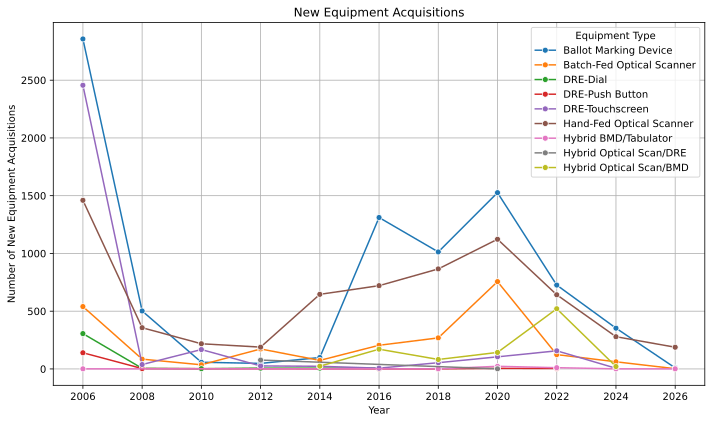

In [58]:
# Group by year and equipment type, and count
df_grouped = df[df['New Equipment']].groupby(['Year', 'Equipment Type']).size().reset_index(name='Count')

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped, x='Year', y='Count', hue='Equipment Type', marker='o')

plt.title('New Equipment Acquisitions')
plt.xlabel('Year')
plt.ylabel('Number of New Equipment Acquisitions')
plt.xticks(sorted(df['Year'].unique()))
plt.grid(True)
plt.tight_layout()
plt.show()


# Compare age of current equipment to typical age at retirement (weighted by N registered voters)

In [ ]:
# sanity check on N voters before using it to calculate weighted average
n = df[df['Year']==2026].drop_duplicates(subset='FIPS code', keep='first')['Registered Voters'].sum()
f"{n:,} registered voters across jurisdictions with voting equipment in 2026"

# https://www.eac.gov/sites/default/files/2024-11/2022_EAVS_Report_508c.pdf#page=6
# "More than 203 million individuals were
# active registered voters for the 2022 general election,"
# this is close enough, i think! sanity check passed

'221,877,727 registered voters across jurisdictions with voting equipment in 2026'

In [79]:
# Function to calculate weighted average and weighted std
def weighted_stats(group):
    weights = group["Registered Voters"]
    values = group["Years in Use"]
    
    # Weighted average
    avg = np.average(values, weights=weights)
    
    # Weighted standard deviation
    variance = np.average((values - avg)**2, weights=weights)
    std_dev = np.sqrt(variance)

    N = len(group)
    
    return pd.Series({
        "Weighted Avg Age": avg,
        "Weighted Std Age": std_dev,
        "N": N
    })

filtered_df = df.dropna(subset=['Registered Voters', 'Years in Use', 'Equipment Type'])
# Apply function by Equipment Type
age_at_retirement = filtered_df[filtered_df['Final Year in Use']==True].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()

# View result
age_at_retirement

current_age = filtered_df[filtered_df['Year'] == 2026].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()

retirement_df = pd.merge(current_age, age_at_retirement, on='Equipment Type', how='left', suffixes=(' Current', ' At Retirement'))
retirement_df

,Equipment Type,Weighted Avg Age Current,Weighted Std Age Current,N Current,Weighted Avg Age At Retirement,Weighted Std Age At Retirement,N At Retirement
0,Ballot Marking Device,7.429488,3.979225,4996.0,7.579312,5.588965,3507.0
1,Batch-Fed Optical Scanner,6.872333,2.662645,1506.0,8.604455,4.925500,1273.0
2,DRE-Dial,20.000000,0.000000,3.0,12.914681,3.228052,344.0
3,DRE-Push Button,21.068044,4.996317,164.0,16.472553,4.687411,191.0
4,DRE-Touchscreen,6.422046,1.484240,235.0,7.861057,5.532619,3972.0
5,Hand-Fed Optical Scanner,7.750939,4.611632,4310.0,9.156900,5.365025,5924.0
6,Hybrid BMD/Tabulator,4.672151,1.748084,34.0,0.774858,0.974326,4.0
7,Hybrid Optical Scan/BMD,7.953540,2.680630,939.0,2.119910,1.348339,23.0
8,Hybrid Optical Scan/DRE,12.430983,3.176526,78.0,NaN,NaN,NaN


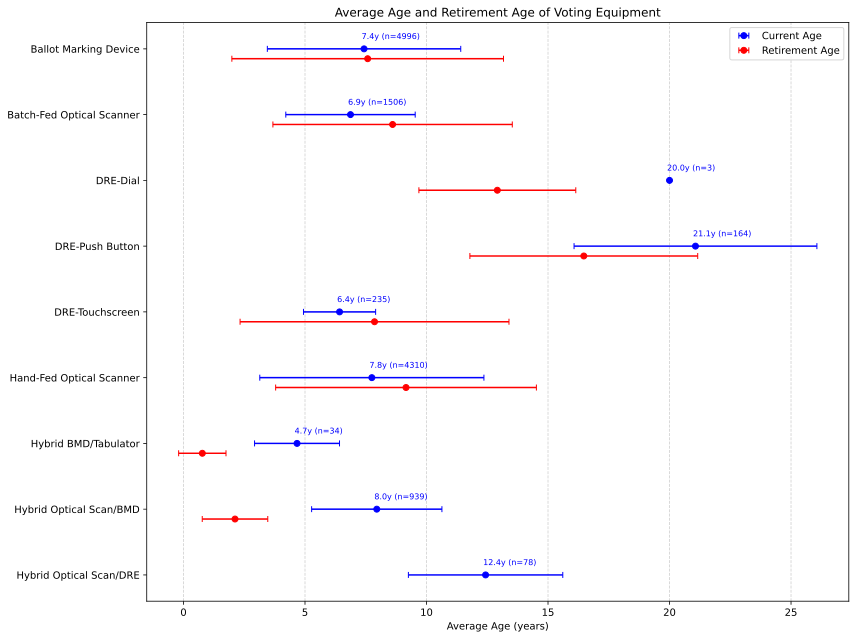

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
y = np.arange(len(retirement_df))

# Plot current age
ax.errorbar(retirement_df['Weighted Avg Age Current'], y, xerr=retirement_df['Weighted Std Age Current'],
            fmt='o', color='blue', label='Current Age', capsize=3)

# Annotate current age
for i, row in retirement_df.iterrows():
    label = f"{row['Weighted Avg Age Current']:.1f}y (n={int(row['N Current'])})"
    ax.text(row['Weighted Avg Age Current'] - 0.1, y[i] - 0.15, label, color='blue', fontsize=8)

# Plot retirement age
for i, row in retirement_df.iterrows():
    if pd.notnull(row['Weighted Avg Age At Retirement']):
        label = 'Retirement Age' if i == 0 else ''
        ax.errorbar(row['Weighted Avg Age At Retirement'], y[i] + 0.15,
                    xerr=row['Weighted Std Age At Retirement'], fmt='o', label=label,
                    color='red', capsize=3)

# Formatting
ax.set_yticks(y)
ax.set_yticklabels(retirement_df['Equipment Type'])
ax.invert_yaxis()  # So first row is on top
ax.set_xlabel('Average Age (years)')
ax.set_title('Average Age and Retirement Age of Voting Equipment')
ax.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Histogram of ages

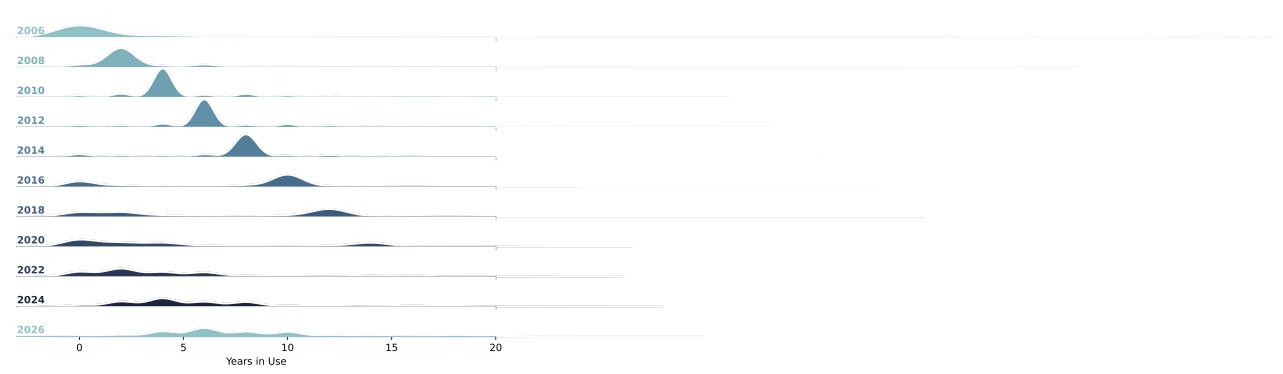

In [ ]:
# using sample seaborn code https://seaborn.pydata.org/examples/kde_ridgeplot

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Year", hue="Year", aspect=15, height=.5, palette=pal)

bw_adjust = 1 # smoothing

g.map(sns.kdeplot, "Years in Use",
      bw_adjust=bw_adjust, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Years in Use", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes)

g.map(label, "Years in Use")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.01)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlim=(-3, 20))
g.despine(bottom=True, left=True)

# todo: make this a series of plain unsmoothed histograms?
# make population weighted?


## Peak Detection / Measurement

Started messing around with identifying peaks for each year, and measuring their area. My goal was to be able to select the two-three largest peaks and then measure the time between them.

Used chatgpt and drew a little from [this method](https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data), which is for timeseries data so not right for this. 

In [179]:
years = voting_df["Year"].unique()

/var/folders/4t/gs7xjwb92bd6lfy7w82b3s4r0000gn/T/ipykernel_89156/3055223857.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


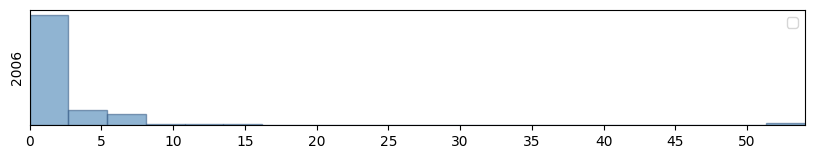

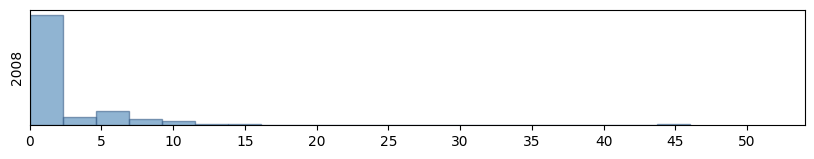

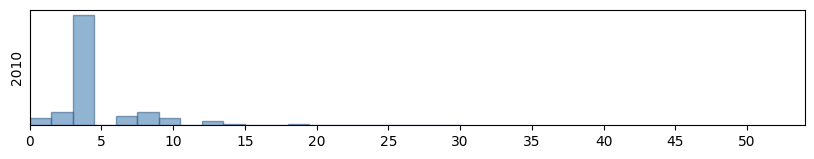

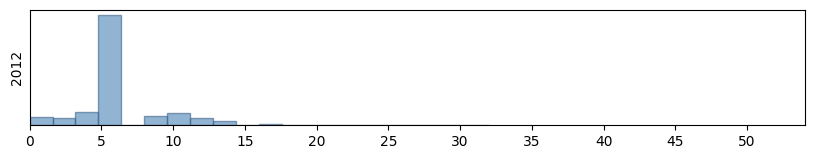

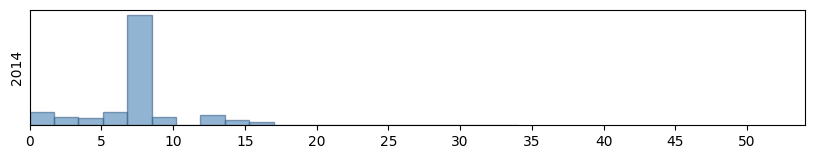

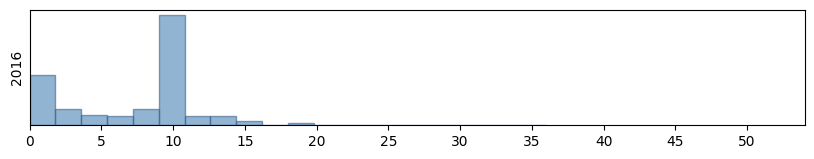

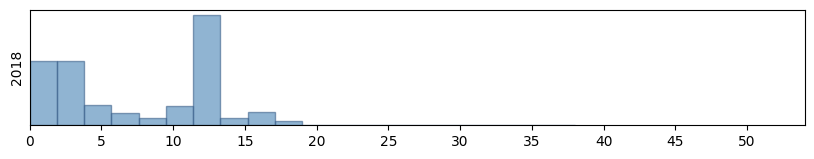

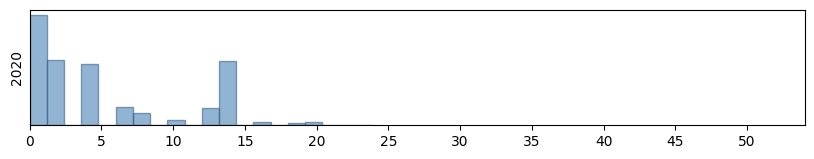

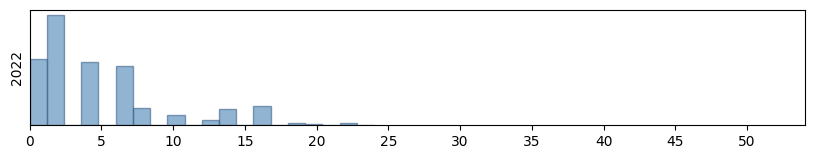

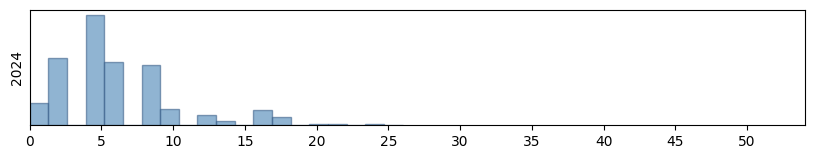

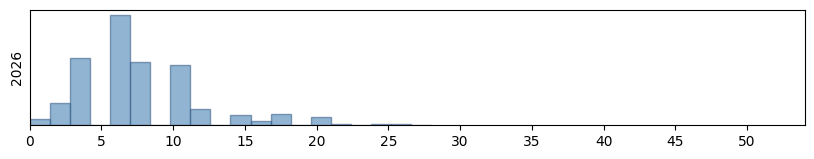

In [180]:
# Peak detection with smoothing and padding
def get_smoothed_peaks(hist_vals, bin_centers, sigma=0.5, prominence=500, distance=2):
    hist_vals_padded = np.insert(hist_vals, 0, 0)  # Add 0 at beginning to capture first peak
    smoothed_vals = gaussian_filter1d(hist_vals_padded, sigma=sigma)  # Apply Gaussian smoothing
    peak_indices, properties = scipy.signal.find_peaks(smoothed_vals, prominence=prominence, distance=distance)
    peak_indices = peak_indices[peak_indices > 0] - 1  # Adjust indices after padding
    return peak_indices, smoothed_vals[1:], properties["prominences"]  # Remove padding from smoothed values

# DataFrame to store peak values and heights
peak_data = []

# Get global x-axis limits
global_xmin, global_xmax = voting_df["Years in Use"].min(), voting_df["Years in Use"].max()

for year in years:
    y = np.array(voting_df[voting_df["Year"] == year]["Years in Use"])
    y = y[~np.isnan(y)]
    

    # Compute histogram
    hist_vals, bin_edges = np.histogram(y, bins=20, density=False) # 15 or 16 works better if using peaks
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers

    # Use modified peak detection with smoothing
    peak_indices, smoothed_vals, peak_heights = get_smoothed_peaks(hist_vals, bin_centers)

    # Store detected peaks in DataFrame
    for i, peak in enumerate(bin_centers[peak_indices]):
        peak_data.append({"Year": year, "Peak Value": peak, "Peak Height": peak_heights[i]})

    # Plot histogram
    plt.figure(figsize=(10, 1.5))
    plt.bar(bin_centers, hist_vals, width=np.diff(bin_edges), alpha=0.6, color="steelblue", edgecolor=blue)

    # UNCOMMENT TO ADD PEAKS AND SMOOTHED LINE

    # # Overlay smoothed line
    # plt.plot(bin_centers, smoothed_vals, color=bpc_darkgray, linestyle="dashed", label="Smoothed Curve",linewidth=.8)

    # # Overlay detected peaks
    # plt.scatter(bin_centers[peak_indices], smoothed_vals[peak_indices], color=red, label="Detected Peaks", s=50, zorder=3)


    # Formatting
    plt.xlim(global_xmin, global_xmax)  # Ensure consistent x-axis limits
    plt.xticks(np.arange(global_xmin, global_xmax + 1, step=5))  # Adjust step size if needed
    plt.yticks([])  # Remove y-axis labels
    plt.ylabel(f"{year}")

    if year == min(years):
        plt.legend()

    plt.savefig(f"figs/{year}.png",bbox_inches='tight')
    plt.show()

# Convert detected peak data to DataFrame
peak_df = pd.DataFrame(peak_data)

In [181]:
from PIL import Image

def create_gif(image_paths, output_path, duration=250):

    frames = [Image.open(image_path) for image_path in image_paths]
    
    # Ensure all frames have the same palette or convert them
    first_frame = frames[0]
    if all(frame.mode != 'P' for frame in frames):
        first_frame.save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)
    else:
        first_frame.save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)

if __name__ == "__main__":
    image_paths = [f"figs/{year}.png" for year in years]
    output_gif_path = "figs/animation.gif"
    create_gif(image_paths, output_gif_path)

In [182]:
# peak_df.sort_values(by=["Year","Peak Height"],inplace=True,ascending=False)
# peak_diffs = []
# years_peaks = []

# for year in years:
#     if len(peak_df[peak_df["Year"]==year]) > 1: # if more than 1 peak
#         # get difference between top two peaks, store to list
#         peak_diffs += [abs(peak_df[peak_df["Year"]==year]["Peak Value"].iloc[0] - peak_df[peak_df["Year"]==year]["Peak Value"].iloc[1])]
#         # store relevant year to list
#         years_peaks += [year]
    
# peak_diffs_df = pd.DataFrame(peak_diffs,index=years_peaks,columns = ["Difference (abs) between two highest peaks"])

# display(peak_diffs_df)
# peak_diffs_df.describe()

# avg_peak_diff = peak_diffs_df["Difference (abs) between two highest peaks"].mean()

## Some descriptives for report outlining

Average equipment age by state

In [183]:
voting_df_26 = voting_df[voting_df["Year"]==2026]

In [184]:
state_eq_len = pd.DataFrame(voting_df_26.groupby(["State"])["Years in Use"].mean())
state_eq_len.sort_values(["Years in Use"],inplace=True,ascending=False)
display(state_eq_len.head(5))
display(state_eq_len.tail(5))

,Years in Use
State,
Oklahoma,14.0
Puerto Rico,14.0
Louisiana,13.791667
Massachusetts,13.476117
Indiana,12.975124


,Years in Use
State,
New Jersey,4.923077
Kentucky,4.628571
South Carolina,4.311927
Mississippi,4.235294
Hawaii,4.0


In [185]:
print(f"Percent of states and territories whose average equipment age exceed {round(voting_eq_avg_life,1)} years:")
print(round((len(state_eq_len[state_eq_len["Years in Use"]>voting_eq_avg_life])/len(state_eq_len))*100,1))

Percent of states and territories whose average equipment age exceed 5.7 years:
85.5


Age of equipment over time

In [308]:
voting_df

,FIPS code,State,Jurisdiction,Equipment Type,Manufacturer,Model,First Year in Use,VVPAT,Election Day Standard,Election Day Accessible,Early Voting Standard,Early Voting Accessible,Mail Ballot/Absentee Equipment,Notes on usage,Year,Registered Voters,New Equipment,Years in Use,is_new
0,0100100000,Alabama,Autauga County,Ballot Marking Device,ES&S,AutoMARK,2006,NaN,No,Yes,No,No,No,NaN,2006,29652,True,0,True
1,0100100000,Alabama,Autauga County,Hand-Fed Optical Scanner,ES&S,Optech IIIP-Eagle,2002,NaN,Yes,No,No,No,Yes,NaN,2006,29652,False,4,False
3,0100300000,Alabama,Baldwin County,Ballot Marking Device,ES&S,AutoMARK,2006,NaN,No,Yes,No,No,No,NaN,2006,97858,True,0,True
4,0100300000,Alabama,Baldwin County,Hand-Fed Optical Scanner,ES&S,Optech IIIP-Eagle,2002,NaN,Yes,No,No,No,Yes,NaN,2006,97858,False,4,False
6,0100500000,Alabama,Barbour County,Ballot Marking Device,ES&S,AutoMARK,2006,NaN,No,Yes,No,No,No,NaN,2006,16395,True,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279742,5604100000,Wyoming,Uinta County,Ballot Marking Device,ES&S,ExpressVote,2020,NaN,No,Yes,No,Yes,No,NaN,2026,8574,False,6,False
279744,5604300000,Wyoming,Washakie County,Hand-Fed Optical Scanner,ES&S,DS200,2020,NaN,Yes,No,No,No,Yes,NaN,2026,3810,False,6,False
279745,5604300000,Wyoming,Washakie County,Ballot Marking Device,ES&S,ExpressVote,2020,NaN,No,Yes,No,No,No,NaN,2026,3810,False,6,False
279747,5604500000,Wyoming,Weston County,Hand-Fed Optical Scanner,ES&S,DS200,2020,NaN,Yes,No,No,No,Yes,NaN,2026,3426,False,6,False


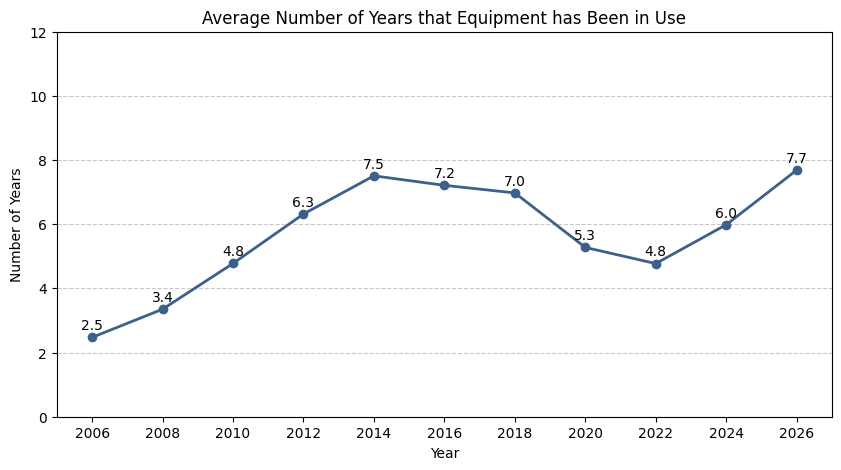

In [333]:
years_in_use = voting_df.groupby(["Year"])["Years in Use"].mean().reset_index()

# Ensure "Year" is treated as numeric
years_in_use["Year"] = years_in_use["Year"].astype(int)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years_in_use["Year"], years_in_use["Years in Use"], marker="o", linestyle="-", color=blue, linewidth=2)

# Add data labels
for i, value in enumerate(years_in_use["Years in Use"]):
    ax.text(years_in_use["Year"][i], value+.15, f"{value:.1f}", ha="center", va="bottom", fontsize=10, color="black")

# Formatting
ax.set_ylabel("Number of Years", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.set_title("Average Number of Years that Equipment has Been in Use", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")

plt.ylim(0, 12)
plt.savefig("figs/avg_years_in_use.png")
plt.show()

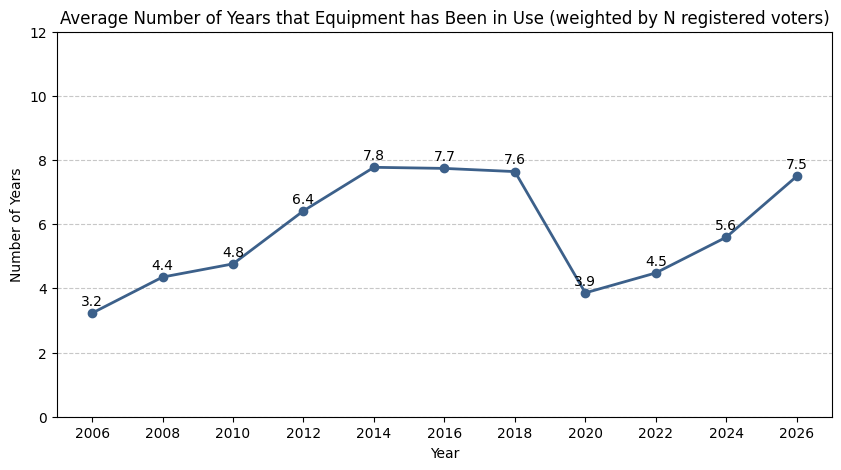

In [334]:
# Compute weighted average years in use per year
filtered_voting_df = voting_df.dropna(subset=["Years in Use", "Registered Voters"])

years_in_use = (
    filtered_voting_df.groupby("Year")
    .apply(lambda x: np.average(x["Years in Use"], weights=x["Registered Voters"]), include_groups=False)
    .reset_index(name="Weighted Years in Use")
)

# Ensure "Year" is treated as numeric
years_in_use["Year"] = years_in_use["Year"].astype(int)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years_in_use["Year"], years_in_use["Weighted Years in Use"], marker="o", linestyle="-", color=blue, linewidth=2)

# Add data labels
for i, value in enumerate(years_in_use["Weighted Years in Use"]):
    ax.text(years_in_use["Year"][i], value + 0.15, f"{value:.1f}", ha="center", va="bottom", fontsize=10, color="black")

# Formatting
ax.set_ylabel("Number of Years", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.set_title("Average Number of Years that Equipment has Been in Use (weighted by N registered voters)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")

plt.ylim(0, 12)
plt.savefig("figs/weighted_avg_years_in_use.png")
plt.show()


When new voting equipment infusions happen

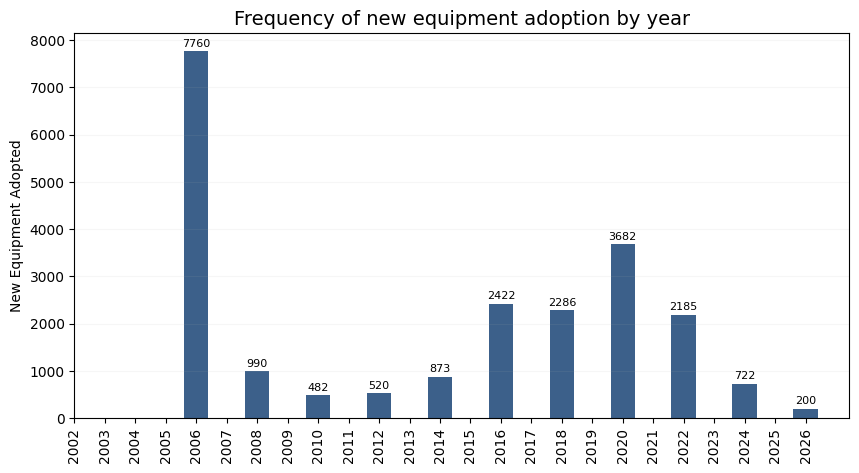

In [134]:
year_enacted = [2002, 2018, 2020, 2020, 2022, 2023, 2024, 2025,2026]
federal_funding_millions = [3650, 380, 400, 425, 75, 75, 55, 15,0]

# Compute new equipment counts per year
new_equipment_counts = voting_df.groupby("Year")["New Equipment"].sum()

# Convert index to integers for consistent plotting
new_equipment_counts.index = new_equipment_counts.index.astype(int)

# Ensure all years are included in the x-axis range
all_years = np.arange(min(year_enacted), max(year_enacted) + 1)

# Align federal funding with years
funding_dict = dict(zip(year_enacted, federal_funding_millions))
funding_values = [funding_dict.get(year, 0) for year in all_years]  # Fill missing years with 0

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.grid(axis="y", linestyle="-", alpha=0.1)

# Primary y-axis (New Equipment Adoption)
ax1.bar(new_equipment_counts.index, new_equipment_counts, color=blue)
ax1.set_ylabel("New Equipment Adopted")

# Add data labels
for year, value in new_equipment_counts.items():
    ax1.text(year, value + 100, str(value), ha="center", fontsize=8)

# Secondary y-axis (Federal Funding)
# ax2 = ax1.twinx()
# ax2.bar(all_years, funding_values, color=pink, alpha=0.6, label="Federal Funding ($M)", width=0.6)
# ax2.set_ylabel("Federal Funding (Millions $)", fontsize=12, color="gray")
# ax2.tick_params(axis="y", labelcolor="gray")

# Set x-axis to show all years
ax1.set_xticks(all_years)
ax1.set_xticklabels(all_years, rotation=90)

# Titles & Legends
ax1.set_title("Frequency of new equipment adoption by year", fontsize=14)
plt.savefig("figs/new_eq_freq_gap.png")
plt.show()